# Introduction

It contains 8 different classes.

    o	Euglena

    o	Paramecium 

    o	Spherical Bacteria

    o	Rod Bacteria

    o	Hydra

    o	Yeast

    o	Spiral Bacteria

    o	Amoeba



# Imports

In [1]:
import os,glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from sklearn.metrics import classification_report
import numpy as np
from os import path, listdir

In [3]:
#  Specify root path
root_path = 'C:/Users/gabis/Downloads/project/Micro_Organism'
name_class = os.listdir(root_path)

In [4]:
dataset_Path = list(glob.glob(root_path+'/**/*.*'))

In [5]:
labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1],dataset_Path))

In [6]:
dataset_Path = pd.Series(dataset_Path,name = 'FilePath').astype(str)
labels = pd.Series(labels,name='Label')
data = pd.concat([dataset_Path,labels],axis =1)
data = data.sample(frac=1).reset_index(drop= True)
data.head(5)

,FilePath,Label
0,C:/Users/gabis/Downloads/project/Micro_Organis...,Spherical_bacteria
1,C:/Users/gabis/Downloads/project/Micro_Organis...,Euglena
2,C:/Users/gabis/Downloads/project/Micro_Organis...,Paramecium
3,C:/Users/gabis/Downloads/project/Micro_Organis...,Euglena
4,C:/Users/gabis/Downloads/project/Micro_Organis...,Paramecium


# Data Visualization

In [7]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]-10,y[i], ha = 'center')

In [8]:
counts = data.Label.value_counts()

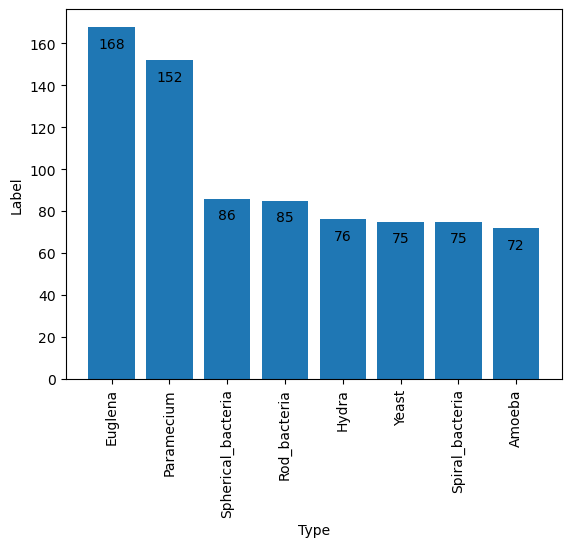

In [9]:
plt.bar(counts.index, counts)
def add_labels(index, y):
    for i in range(len(index)):
        plt.text(i, y.iloc[i]-10, y.iloc[i], ha='center')
add_labels(counts.index, counts)
plt.xticks(rotation=90)
plt.xlabel('Type')
plt.ylabel('Label')
plt.show()


Dataset is unbalanced, 2 classes are highly populated ,to balance the dataset and to train model we need to apply image augmentation on dataset to increase the training data.

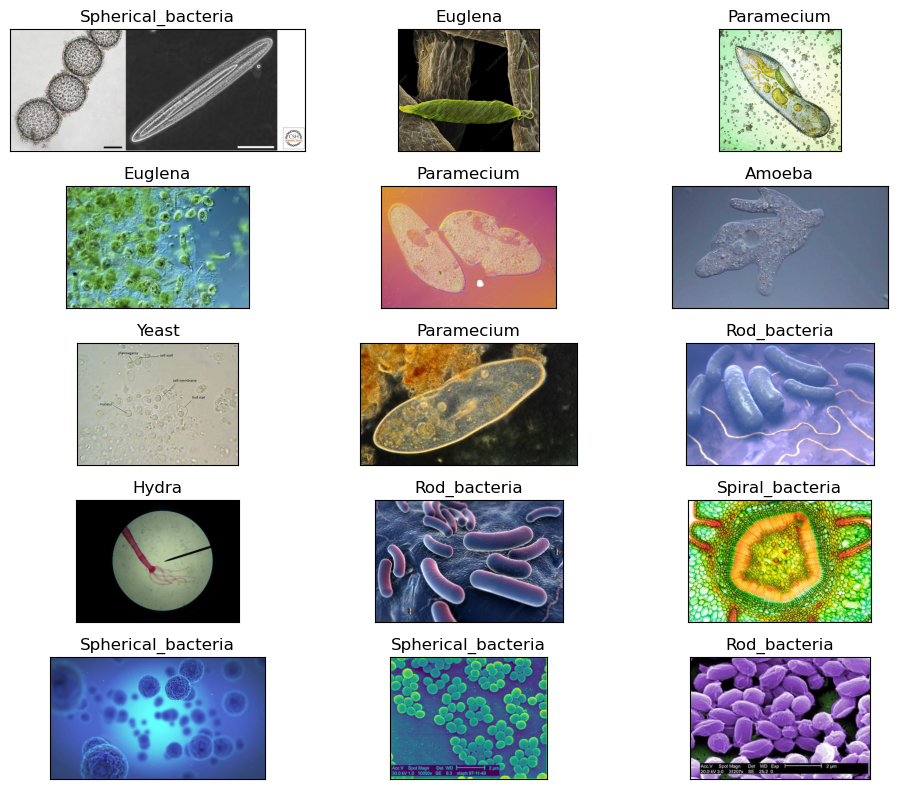

In [10]:
fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(10,8),subplot_kw={'xticks':[],'yticks':[]})
for i ,ax,in enumerate(axes.flat):
  ax.imshow(plt.imread(data.FilePath[i]))
  ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

After visualizing the images, we can clearly say that we need to resize each image, to make them more uniform size.

# Spliting dataset and Image augmentation on training,validating data

In [11]:
train,rem = train_test_split(data,test_size =0.20,random_state = 42 )
test,valid = train_test_split(data,test_size =0.50,random_state = 42 )

**Note:** The accuracy model also depends on how the dataset is partitioned, each time the dataset is partitioned with randomness it will give a different accuracy.

The **ImageDataGenerator** class allows your model to **receive new forms of images at each epoch**. But remember it only returns the transformed images and **doesn't add it to the set of images you have**.

In [12]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
)
test_datagen = ImageDataGenerator()

Here we are not implementing any image augmentation on test data, we will test the model on **realistic images**.

In [13]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                              class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = True,seed =42)
valid_gen = train_datagen.flow_from_dataframe(dataframe = valid,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                              class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = False,seed =42)
test_gen =  test_datagen.flow_from_dataframe(dataframe = test,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                             class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = False,seed =42)

Found 631 validated image filenames belonging to 8 classes.
Found 395 validated image filenames belonging to 8 classes.
Found 394 validated image filenames belonging to 8 classes.


In [14]:
NO_CLASSES = max(train_gen.class_indices.values()) + 1
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x) #used to replace fully connected layers in classical CNNs.
#It will generate one feature map for each corresponding category of the classification task in the last mlpcov layer(1 X 1 convolutions).
x = Dense(1024,activation='relu')(x)   # add dense layers so learn more complex functions and classify for better results.    
x = Dense(1024,activation='relu')(x)   # dense layer 2
x = Dense(512,activation='relu')(x)    # dense layer 3

preds = Dense(NO_CLASSES,activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs = preds) #create a new model with the base model's original input 


Here in VGG16, include_top is false because we want to add more dense layers.
Most models are a series of convolutional layers followed by one or a few dense (or fully connected) layers.
include_top Help us select the last dense layer or not.
Convolution layers act as feature extractors.They identiy a series of patterns in the image ,and each layer can identify more elborate patterns by seeing patterns of patterns.
The dense layes are capable of interpreting the found patterns in order to classify the image of various categories.

# Freezing some layer and Fine tuning rest of model’s layer

Freeze some of layer and fine tune rest of layers. In starting layer model learn about **edges and roundness**.

In [15]:
#don't train the first 19 layers 
for layer in model.layers[:19]:
    layer.trainable=False
#train the rest of the layers
for layer in model.layers[19:]:
    layer.trainable=True

# Model architecture

In [16]:
tf.keras.utils.plot_model(model,'model.png',show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
#Compiling Model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
#callbacks
my_callbacks = [EarlyStopping(monitor = 'val_accuracy',min_delta=0,patience=2,mode='auto')]

In [19]:
model.fit(train_gen,validation_data = valid_gen,
          epochs=25,callbacks=[my_callbacks])

Epoch 1/25
79/79 [==============================] - 139s 2s/step - loss: 2.2363 - accuracy: 0.4406 - val_loss: 1.0091 - val_accuracy: 0.6329
Epoch 2/25
79/79 [==============================] - 155s 2s/step - loss: 0.9228 - accuracy: 0.7052 - val_loss: 0.7367 - val_accuracy: 0.7823
Epoch 3/25
79/79 [==============================] - 181s 2s/step - loss: 0.6880 - accuracy: 0.7686 - val_loss: 0.7397 - val_accuracy: 0.7570
Epoch 4/25
79/79 [==============================] - 158s 2s/step - loss: 0.6436 - accuracy: 0.7971 - val_loss: 0.8249 - val_accuracy: 0.7519


In [20]:
model.evaluate(test_gen)

50/50 [==============================] - 41s 821ms/step - loss: 0.5162 - accuracy: 0.8477


[0.5161856412887573, 0.8477157354354858]

In [21]:
#predict the label of the test_gen
pred = model.predict(test_gen) 
pred = np.argmax(pred,axis=1)
labels = (train_gen.class_indices) 
labels = dict((v,k) for k,v, in labels.items()) #
pred = [labels[k]for k in pred]

50/50 [==============================] - 45s 901ms/step


In [22]:
y_test = list(test.Label)
print(classification_report(y_test,pred))

                    precision    recall  f1-score   support

            Amoeba       1.00      0.83      0.91        35
           Euglena       0.85      0.97      0.90        68
             Hydra       1.00      0.67      0.80        36
        Paramecium       0.93      0.87      0.90        78
      Rod_bacteria       0.69      0.88      0.77        49
Spherical_bacteria       0.69      1.00      0.82        47
   Spiral_bacteria       0.93      0.65      0.76        40
             Yeast       0.97      0.76      0.85        41

          accuracy                           0.85       394
         macro avg       0.88      0.83      0.84       394
      weighted avg       0.87      0.85      0.85       394



Model achives 92% accuracy.

# Model Predictions

Storing class labels

In [23]:
labels = (train_gen.class_indices)

In [24]:
labels

{'Amoeba': 0,
 'Euglena': 1,
 'Hydra': 2,
 'Paramecium': 3,
 'Rod_bacteria': 4,
 'Spherical_bacteria': 5,
 'Spiral_bacteria': 6,
 'Yeast': 7}

In [25]:
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)
labels = dict((v,k) for k,v, in labels.items())
pred = [labels[k]for k in pred]

50/50 [==============================] - 43s 870ms/step


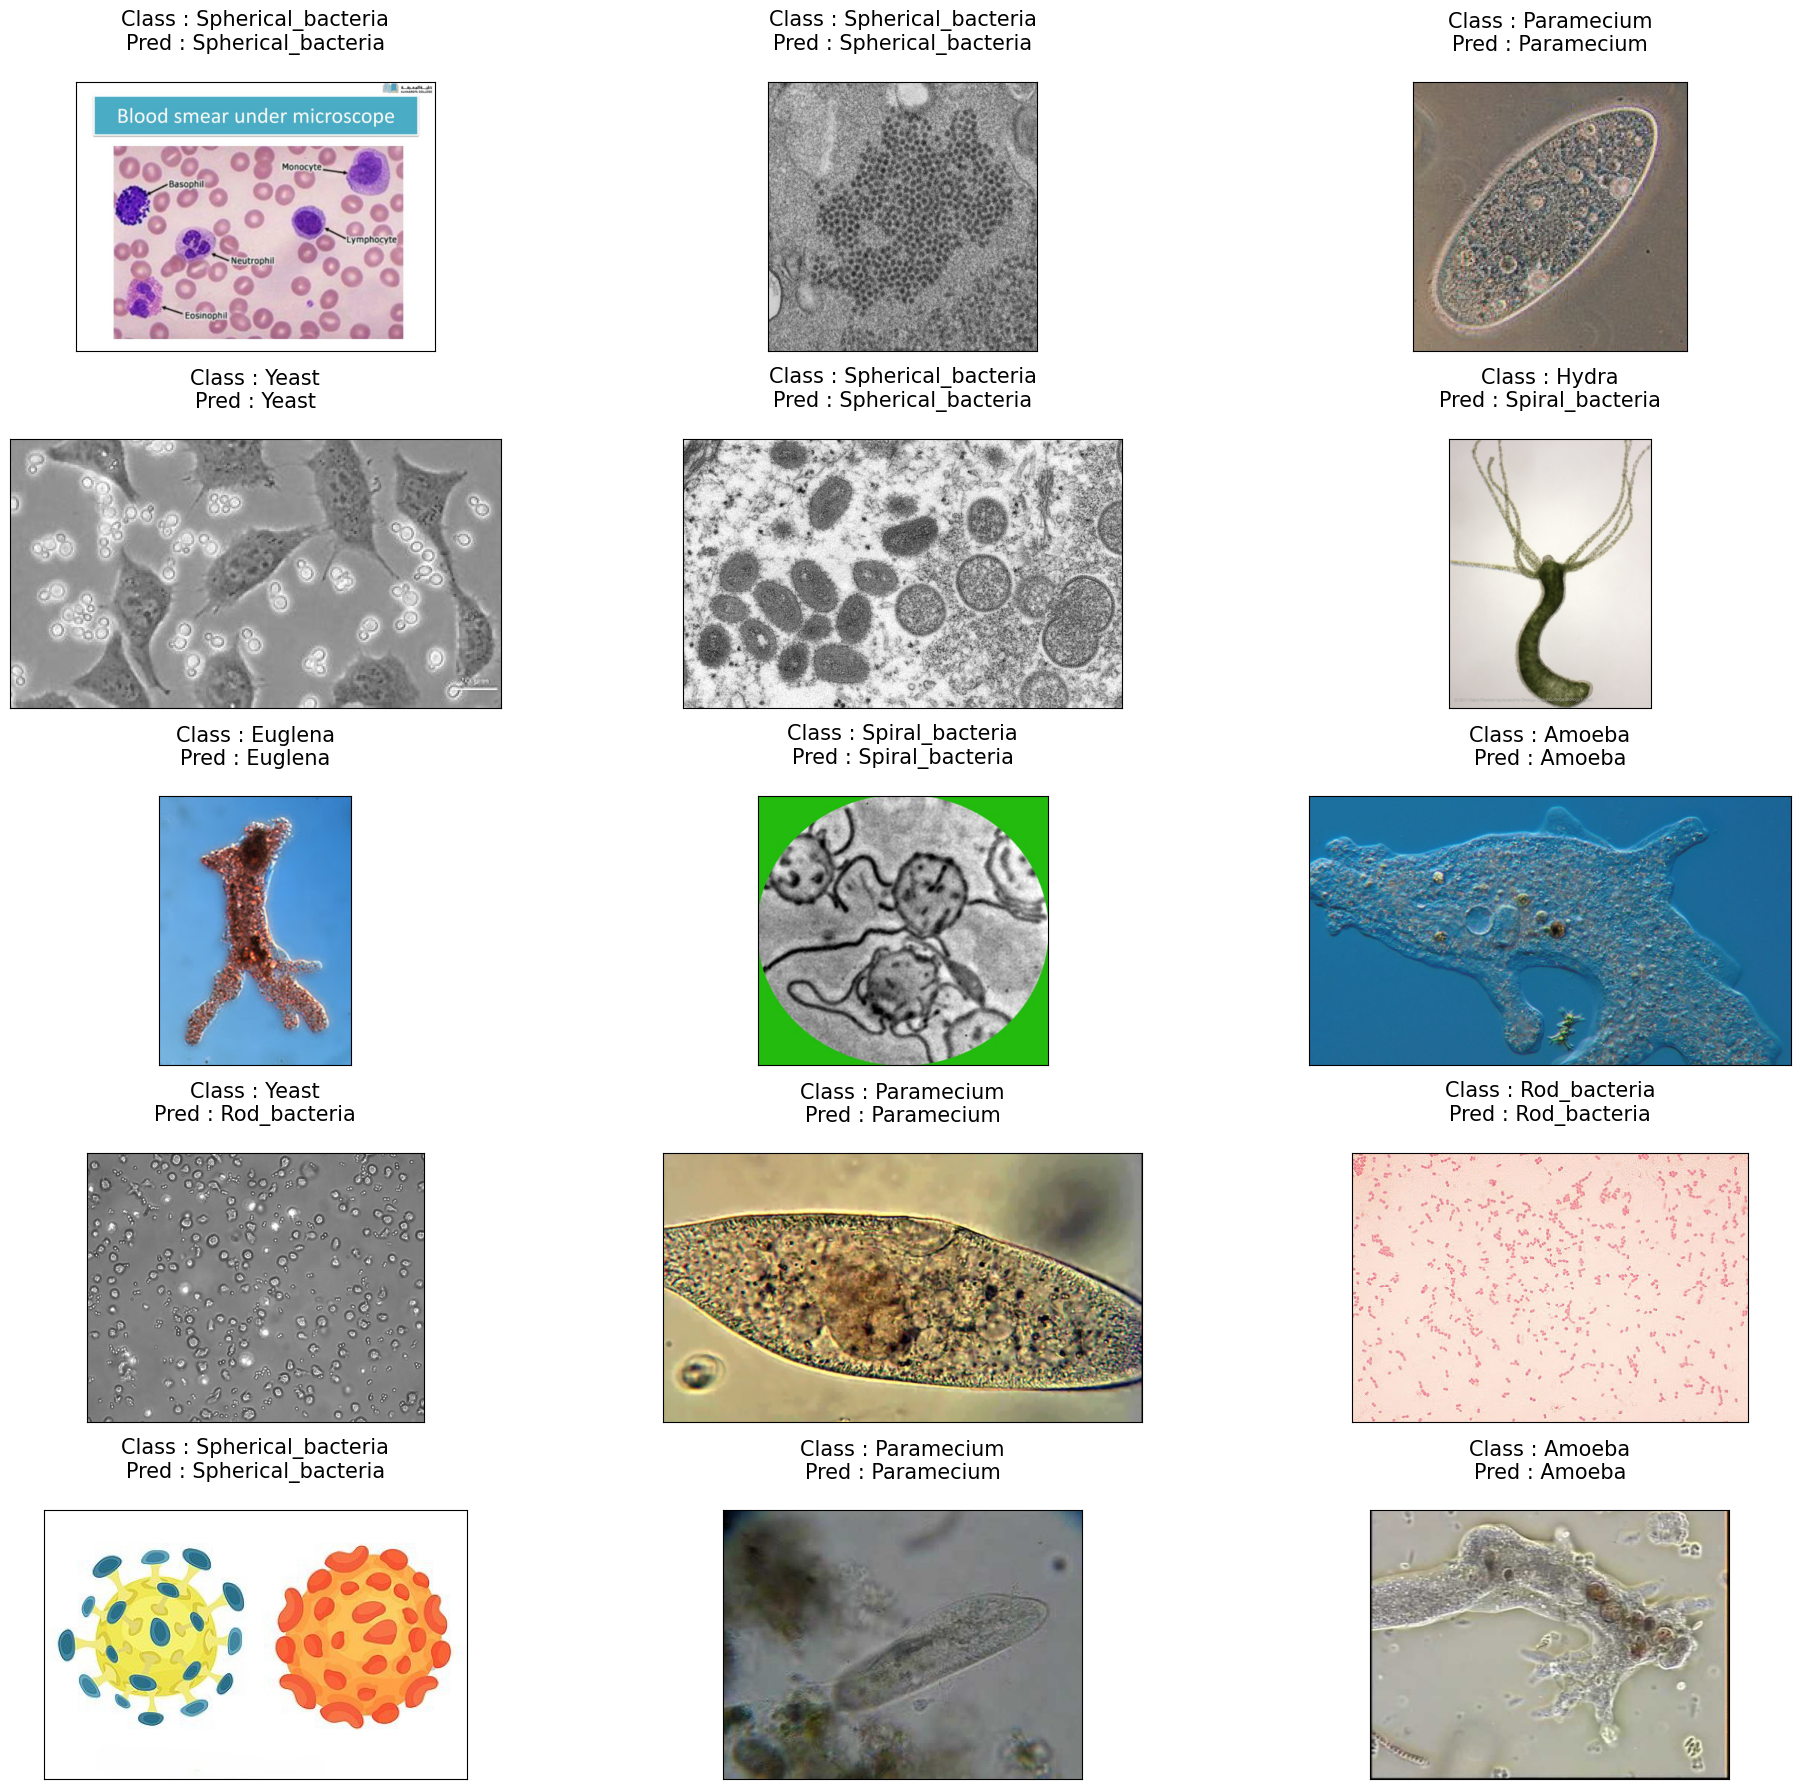

In [26]:
fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(20,18),subplot_kw={'xticks':[],'yticks':[]})
for i ,ax,in enumerate(axes.flat):
    ax.imshow(plt.imread(test_gen.filenames[i]))
    title =str( f"Class : {labels[test_gen.classes[i]]}\nPred : {pred[i]}\n")
    ax.set_title(title,fontsize=15)
plt.tight_layout()
plt.show()